# Studying wikipedia page importance with Directional Networks


Wikipedia is a free open-collaborative encyclopedia created and maintained by a community of volunteer contributors. 

Inside each wikipedia page there is an in-depth description of the topic, with multiple references to other topics mentioned along the text.

This study focuses on wikipedia pages about people and how the different pages reference each other.

A json composed of **1.259.797** different people who have an article written on the english wikipedia is used. Each person in this JSON has a list with all the other people that they mention.

This data is studied using a Directional Network that keeps track of the direction of the references.

The aim of the project is to answer the following questions:

1. How are the articles connected? Do the articles normally reference people born before, after or in the same cohort of the subject of the page?
2. Which are the most referenced people? Which are the people most essential to linking different pages together?

## 1. The data

The data is available on https://www.kaggle.com/simonburton/wikipedia-people-network.

It contains about **1.259.797** people born from 1830 to 2003.
The features included are:

* 'birth_year': The year of birth of this person.
* 'link': Which are the people it references.

## 2. Data processing

Additionally to the available data, tree new features were created: 

* 'number_mentions': The number of times the page is referenced by the others.
* 'referenced_pages': The number of different pages referenced by the page.
* 'year_difference_vector': An array which contains the difference between the birth year of the page and the birth year of each reference.

The processed data is shown below

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import json
import matplotlib
from urllib.parse import unquote
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import Markdown as md
from collections import Counter
import operator


In [2]:
#reading json file
wikipedia_df = pd.read_json('./input/input.json')

#Creating the year of birth variable
wikipedia_df['birth_year']=wikipedia_df['dob'].apply(lambda x:x[0])
wikipedia_df.drop(['dob'],axis=1,inplace=True)

#Creating the referenced_pages - the total number of other people the page references
wikipedia_df['referenced_pages']=wikipedia_df['links'].apply(lambda x:len(x))

#Counting the number of times each person is mentioned by other pages
counts_per_person={}
total_connections=0
for index, row in wikipedia_df.T.iteritems():
    for linked_name in row['links']:
        total_connections+=1
        if linked_name in counts_per_person:
            counts_per_person[linked_name]+=1
        else:
            counts_per_person[linked_name]=int(1)
mentions=pd.DataFrame(list(zip(counts_per_person.keys(),counts_per_person.values())),columns=['name','number_mentions'])

#Unifying all variables in a single table
wikipedia_unified=wikipedia_df.merge(mentions,on='name',how='outer')

#Creating list with difference between birth date of person and birth date of each of its references
dict_years=dict(zip(wikipedia_df['name'],wikipedia_df['birth_year']))

def calculate_difference_vector(x):
    list_birth_years=[dict_years[name] for name in x['links']]
    return x['birth_year']*np.ones(len(list_birth_years))-list_birth_years

wikipedia_unified['year_difference_vector']=wikipedia_unified.apply(lambda x:calculate_difference_vector(x),axis=1)

#Showing top 5 most mentioned people
wikipedia_unified.set_index('name').sort_values('number_mentions',ascending=False).head(5)

,links,birth_year,referenced_pages,number_mentions,year_difference_vector
name,,,,,
Barack_Obama,"[Alan_Keyes, Alexi_Giannoulias, Alice_Palmer_(...",1961,98,5472.0,"[11.0, -15.0, 22.0, 7.0, 19.0, 2.0, -10.0, 5.0..."
George_W._Bush,"[Adam_McKay, Al_Gore, Alan_Greenspan, Alan_Key...",1946,122,4365.0,"[-22.0, -2.0, 20.0, -4.0, -9.0, 18.0, -5.0, -1..."
Bill_Clinton,"[Al_Gore, Ann_Claire_Williams, Barack_Obama, B...",1946,109,3768.0,"[-2.0, -3.0, -15.0, 23.0, 3.0, 15.0, 13.0, 74...."
Ronald_Reagan,"[Aaron_Mitchell_(murderer), Alan_Greenspan, Al...",1911,122,3583.0,"[-19.0, -15.0, 24.0, -25.0, -25.0, -36.0, -29...."
Donald_Trump,"[Abdel_Fattah_el-Sisi, Abu_Bakr_al-Baghdadi, A...",1946,117,3378.0,"[-8.0, -25.0, -2.0, -12.0, -25.0, -11.0, -7.0,..."


## 3. Network overview

Before moving into a more detailed analysis of the network, it is interesting to understand the general behavior of the network.

Each page in the network has an in-Degree value, which is the number of other people by which this page was mentioned ('number_mentions'). This value is an integer discrete value.

The total number of people in each in-Degree value was counted and is shown below. Each blue dot represents the fraction of nodes that have a given in-Degree value.

As expected of a network, most nodes have a low In-Degree value, while a minority of nodes have a high In-Degree value. This follows a power law with equation $P(k)=200k^{-2}$.

The red curve shows the cumulative fraction, which shows:
* **35%** of nodes have an In-Degree value of 1  
* More than **80%** of nodes have a In-Degree value lower than 10.

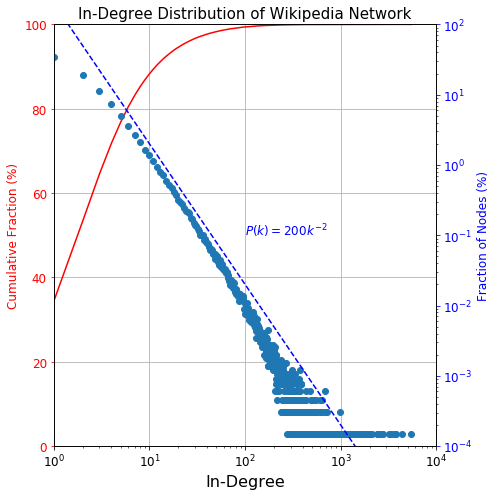

In [3]:
# Getting the fraction of people that each In-Degree value has
grouped=wikipedia_unified.dropna().groupby('number_mentions').count()
grouped['name']=grouped['name']/sum(grouped['name'])

#Calculating Power law curve
alpha=2
C=200
k=np.logspace(start=0,stop=4,num=10)
P=[C*ki**(-alpha) for ki in k]

#Plotting
fig,ax1=plt.subplots(figsize=(7,7))
ax2 = ax1.twinx() 

plt.title('In-Degree Distribution of Wikipedia Network',fontsize=15)
ax2.scatter(grouped.index,100*grouped['name'])
ax1.plot(grouped.index,np.cumsum(100*grouped['name']),'red')

ax2.annotate('$P(k)=200k^{-2}$',(100,0.1),fontsize=12,color='blue')
ax2.plot(k,P,color='blue',linestyle='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='y', colors='blue')
ax1.tick_params(axis='y', colors='red')


ax2.set_ylim(10**-4,10**2)
plt.xlim(10**-0,10**4)
ax1.set_ylim(0,100)
ax1.set_xlabel('In-Degree',fontsize=16)
ax2.set_ylabel('Fraction of Nodes (%)',fontsize=12,color='blue')
ax1.set_ylabel('Cumulative Fraction (%)',fontsize=12,color='red')
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
ax1.grid()


## 3.1 Birth year analysis

Before analysing the network, it is interesting to understand how the page mentions interact for different decades.
First, the people were grouped by decade of birth and the average number of mentions was calculated:

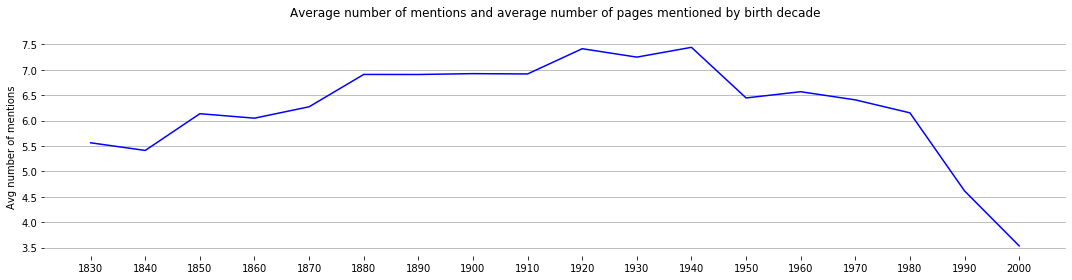

In [22]:
#Creating decades bins and averaging over them
bins= list(np.arange(1830,2003,10))+[2003]
wikipedia_unified['year_bin']=pd.cut(wikipedia_unified['birth_year'],bins,include_lowest=True)
average_by_decade=wikipedia_unified.groupby('year_bin').mean()
average_by_decade.index=[int(x) for x in np.arange(1830,2003,10)]

fig,(ax1)=plt.subplots(1,1,figsize=(15,4),sharex=True)
plt.subplots_adjust(hspace=0.1)
sns.lineplot(x=average_by_decade.index,y='number_mentions',data=average_by_decade,color='blue',ax=ax1,markers='o')
ax1.grid(axis='y')
ax1.set_ylabel('Avg number of mentions')

for ax in [ax1]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
plt.xticks(np.arange(1830,2003,10))
plt.title('Average number of mentions and average number of pages mentioned by birth decade\n');
plt.tight_layout()

The birth decade of the most referenced pages are 1920, 1930 and 1940, while the less referenced decades were from people born after 1980.

In [ ]:
#Finding the age difference between each connection
difference_list=[]
for index,row in wikipedia_unified.iterrows():
    difference_list+=list(row['year_difference_vector'])

In [109]:
md(('Secondly, it is interesting to understand how different is the age of the referenced person and the person that'
   ' referenciates. All **{}** connections inside the network had their difference calculated'
    '\nAs seen in the graph below, it was more common for the people to have a similar age.'.format(len(difference_list))))

Secondly, it is interesting to understand how different is the age of the referenced person and the person that referenciates. All **4353922** connections inside the network had their difference calculated
As seen in the graph below, it was more common for the people to have a similar age.

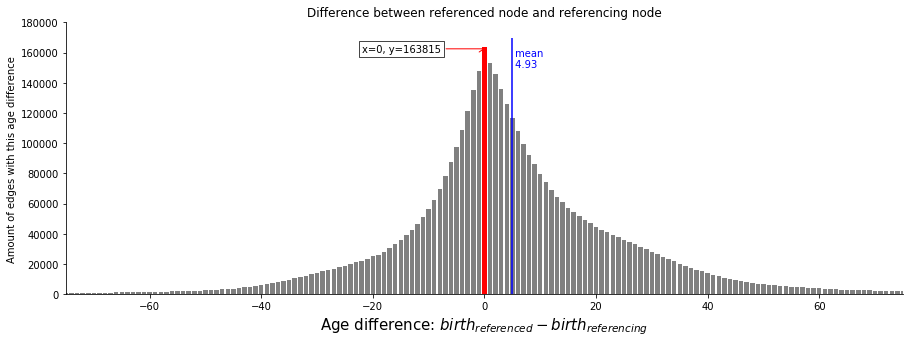

In [111]:
#Function to add annotation to top bar of the barplot
def annot_max(x,y, ax=None):
    dict_values=dict(zip(x,y))
    xmax=max(dict_values.items(),key=operator.itemgetter(1))[0]
    ymax=max(y)

    text= "x={:.0f}, y={:.0f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60",color='red')
    kw = dict(xycoords='data',textcoords="data",
              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-22,ymax+2000), **kw)
    return xmax,ymax

#Counting the number of occurrences grouped by age difference
difference_count=Counter(difference_list)
mean_diff=np.mean(difference_list)

#Plot
fig,ax=plt.subplots(figsize=(15,5))

clrs = ['grey' if (x < max(difference_count.values())) else 'red' for x in difference_count.values() ]
labels = ['grey' if (x < max(difference_count.values())) else 'red' for x in difference_count.values() ]


ax.bar(difference_count.keys(),difference_count.values(),color=clrs)
ax.vlines(mean_diff,0,170000,color='blue')
ax.text(mean_diff,150000,' mean\n {:.2f}'.format(mean_diff),rotation=0,color='blue')

xmax,ymax=annot_max(difference_count.keys(),difference_count.values())

ax.set_ylim(0,180000)
ax.set_xlim(-75,75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.title('Difference between referenced node and referencing node')
plt.ylabel('Amount of edges with this age difference')
plt.xlabel('Age difference: $birth_{referenced}-birth_{referencing}$',size=15);

In [118]:
md(('In fact, the most common age difference was equal to **{:.0f}** and occurred for **{}** connections.'
   '\n By calculating the average difference between the connections, it was found that '
   'the pages usually referenced people that were on average **{:.1f}** years older.').format(xmax,ymax,mean_diff,mean_diff))

In fact, the most common age difference was equal to **0** and occurred for **163815** connections.
 By calculating the average difference between the connections, it was found that the pages usually referenced people that were on average **4.9** years older.

## 4. Key-definitions using a reduced network

Before the main analysis, a smaller network will be explored where some of the key concepts and definitions of a directional network will be presented.

To better visualize the way a directional network works, a smaller number of pages will be used. In this case, only the pages which are referenced by at least **1800** other pages will be considered.

In [4]:
#Keeping only people that were referenced by at least 1800 other wikipedia pages to perform an initial analysis of the
#MultiDirectional Network

minimum_mentions=1800

filtered_members=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]['name']
wikipedia_unified_filtered=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]
wikipedia_unified_filtered.loc[:,'links_filtered']=wikipedia_unified_filtered['links'].apply(lambda x: list(set(x).intersection(filtered_members)))

#Converting strings to readable format
wikipedia_unified_filtered.loc[:,'name']=wikipedia_unified_filtered['name'].apply(lambda x:unquote(x))
wikipedia_unified_filtered.loc[:,'links_filtered']=wikipedia_unified_filtered['links_filtered'].apply(lambda x:[unquote(x0) for x0 in x])
dict_network=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['links_filtered']))

#Creating directional network
net=nx.DiGraph(dict_network)


#Processing features and giving them as attributes to the network
year_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['birth_year']))
number_mentions_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['number_mentions']))
names_dict=dict(zip(wikipedia_unified_filtered['name'],wikipedia_unified_filtered['name']))

nx.set_node_attributes(net, year_dict, 'year')
nx.set_node_attributes(net, number_mentions_dict, 'number_mentions')


#Obtaining the strongly connected subset of the network that has the highest number of nodes.
subnets = sorted(nx.strongly_connected_components(net), key=len,reverse=True)
main_net=net.subgraph(subnets[0])



In [5]:
md('A total of **{}** pages fit this criteria. The network containing these pages is shown below.'.format(len(net)))

A total of **17** pages fit this criteria. The network containing these pages is shown below.

In [6]:
def plot_net(net):
    node_size = [1*nx.get_node_attributes(net, 'number_mentions')[v] for v in net]
    node_color = [1*nx.get_node_attributes(net, 'year')[v] for v in net]

    cmap = plt.cm.autumn
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

    fig,ax=plt.subplots(figsize=(14,14))

    pos = nx.shell_layout(net)

    nodes = nx.draw_networkx_nodes(net, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                                   norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9)
    edges = nx.draw_networkx_edges(
        net,
        pos,
        node_size=node_size,
        arrowstyle="->",
        arrowsize=20,
        edge_color='black',
        width=2,
        alpha=0.4,
    )
    labels=nx.draw_networkx_labels(net,pos,node_labels=names_dict,font_size=10,bold=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    cbar=plt.colorbar(sm)
    plt.title('Directional network of pages with at least 1800 mentions')
    plt.annotate('The size of the nodes represent\n the amount of mentions',(0.5,-1.1))
    cbar.ax.set_ylabel('Birth year', rotation=90)


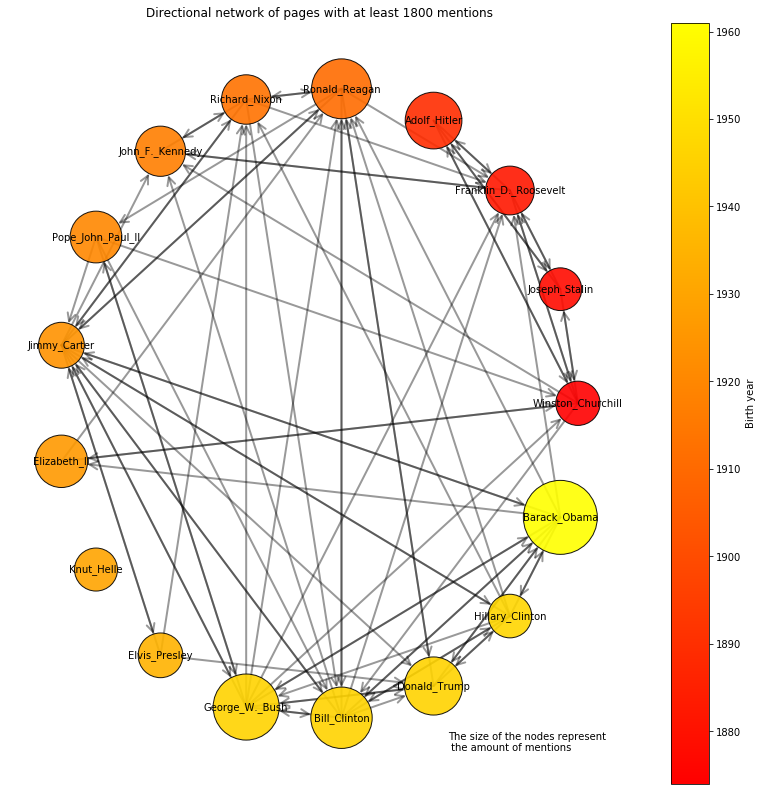

In [7]:
plot_net(net)

Each page is represented by a circle, which is called a node. Each reference is represented by an arrow, which is called an edge.

The size of each circle represents the number of times the node is referenced by all the other pages. Barack Obama is the most referenced page of the dataset, with a total of **5472** mentions.

The circles are colored and ordered according to the year of birth, Winston Churchill has the smallest birth year, while Obama has the highest.

The arrow points from the referencing page to the page it references. Exemplifying with Elizabeth_II:
* Elizabeth's page is referenced by Obama's page;
* Elizabeth's page references Reagan's page;
* Elizabeth's page both references and is referenced by Churchill's page.

One interesting thing to notice in this network is that not all nodes are connected: Knut_Helle neither mentions or is mentioned by the other nodes. The node prevents the use of multiple metrics.

For the analysis of a directional network, it is particularly interesting when the network is strongly connected, as some properties can only be calculated in this type of network. A strongly connected network respects the rule:
* All nodes are capable of reaching any other node of the network by following the direction of the edges.


In [8]:
md('In the case of this network, the strongly connected subset with the highest number of nodes has **{}** nodes and is show below'.format(len(main_net)))

In the case of this network, the strongly connected subset with the highest number of nodes has **16** nodes and is show below

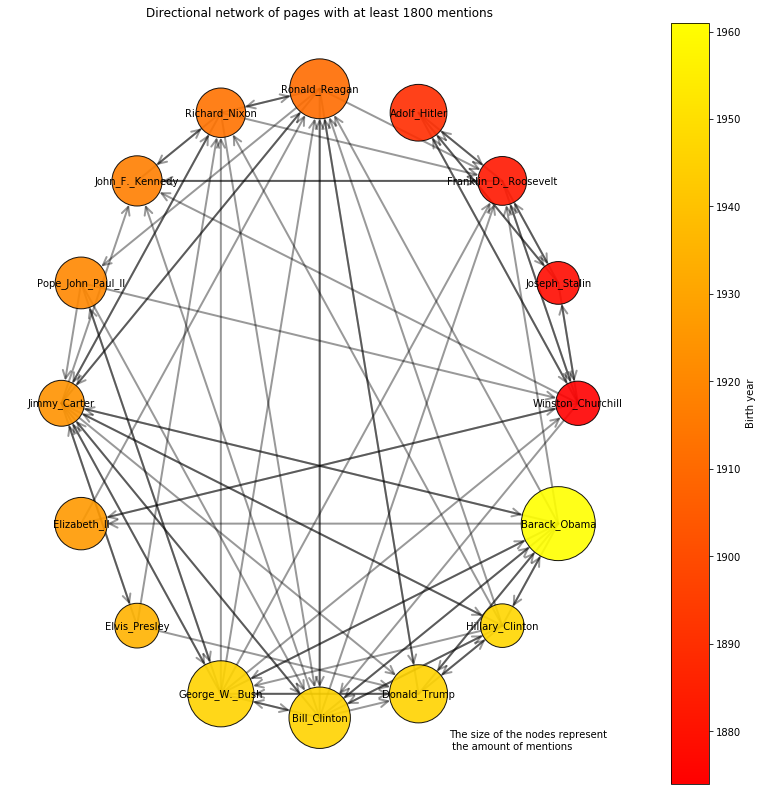

In [9]:
plot_net(main_net)

With this strongly connected network, some extra measurements can be performed.

Before showing these measures, some definitions are presented below:

* Distance (u,v) - Minimum number of edges needed to go from node u to node v.
* Shortest path (u,v) - Path with the lowest number of edges needed to go from node u to node v.
* Diameter (network) - Maximum distance between any pair of nodes.
* Eccentricity (node n) - largest distance between node n and all other nodes.
* Radius (network) - Minimum eccentricity.
* Periphery (network) - Set of nodes that have eccentricity equal to the Diameter.
* Center (network) - Set of nodes that have eccentricity equal to the radius.

As an example, the shortest path between Elvis_Presley and Barack_Obama is: Elvis Presley -> Jimmy Carter -> Barack Obama. It has a distance equal to **2**.


<!--The diameter of this network is equal to **4** (in other words, this is the maximum distance necessary to be traveled for any node to each any other node). The nodes which have their eccentricity equal to the diameter (in other words, they are in the periphery) are: Joseph Stalin, Franklin_D._Roosevelt and Adolf_Hitler. Stalin for example needs the following path to reach Pope_John_Paul_II: Joseph_Stalin -> Winston_Churchill-> Bill_Clinton-> Ronald_Reagan -> Pope_John_Paul_II (**4** edges in total).

The radius of the network is equal to **2**. The only nodes that are in the center (have eccentricity equal to the radius) are: Pope_John_Paul_II, George_W._Bush, Bill_Clinton and Barack_Obama. They only need **2** edges to reach any other node of the network.-->


## 5. Network Analysis

Now that the main definitions were presented in a simpler graph, the same approach is extended for a network with a much larger number of nodes.

This time, only pages that were referenced a total of **120** times will be considered in the analysis. Not all pages were considered since processing more than 1 million nodes would have a very high computational cost.

In [24]:
#Same procedure as previous section, except this time the restrictions are smaller.
minimum_mentions=250

filtered_members2=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]['name']

wikipedia_unified_filtered2=wikipedia_unified[wikipedia_unified['number_mentions']>minimum_mentions]


wikipedia_unified_filtered2.loc[:,'links_filtered']=wikipedia_unified_filtered2['links'].apply(lambda x: list(set(x).intersection(filtered_members2)))
wikipedia_unified_filtered2.loc[:,'name']=wikipedia_unified_filtered2['name'].apply(lambda x:unquote(x))
wikipedia_unified_filtered2.loc[:,'links_filtered']=wikipedia_unified_filtered2['links_filtered'].apply(lambda x:[unquote(x0) for x0 in x])

dict_network2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['links_filtered']))

year_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['birth_year']))
number_mentions_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['number_mentions']))
names_dict2=dict(zip(wikipedia_unified_filtered2['name'],wikipedia_unified_filtered2['name']))

#Building network
net2=nx.DiGraph(dict_network2)
nx.set_node_attributes(net2, year_dict2, 'year')
nx.set_node_attributes(net2, number_mentions_dict2, 'number_mentions')

#Getting biggest strongly connected subset
subnets = sorted(nx.strongly_connected_components(net2), key=len,reverse=True)
main_net2=net2.subgraph(subnets[0])
main_net2_names=list(main_net2.nodes)

In [113]:
#Counting the total number of connections in this network
wikipedia_unified_filtered_final=wikipedia_unified_filtered2[wikipedia_unified_filtered2['name'].isin(main_net2_names)]
wikipedia_unified_filtered_final.loc[:,'links_filtered']=wikipedia_unified_filtered_final['links'].apply(lambda x: list(set(x).intersection(main_net2_names)))

total_connections2=np.sum(wikipedia_unified_filtered_final['links_filtered'].apply(lambda x:len(x)))

In [114]:
md('There are a total of **{}** pages that fit this criteria. By considering only'.format(len(net2))+\
   ' the biggest strongly connected subset, the final network had a total of **{}** nodes.'.format(len(main_net2))+\
  '<br> Although this represents only **{:.2f}'.format(len(main_net2)/len(wikipedia_df)*100)+\
   '%** of all nodes, it represents **{:.2f}%** of all edge connections'.format(total_connections2/total_connections*100))

There are a total of **796** pages that fit this criteria. By considering only the biggest strongly connected subset, the final network had a total of **790** nodes.<br> Although this represents only **0.06%** of all nodes, it represents **0.29%** of all edge connections

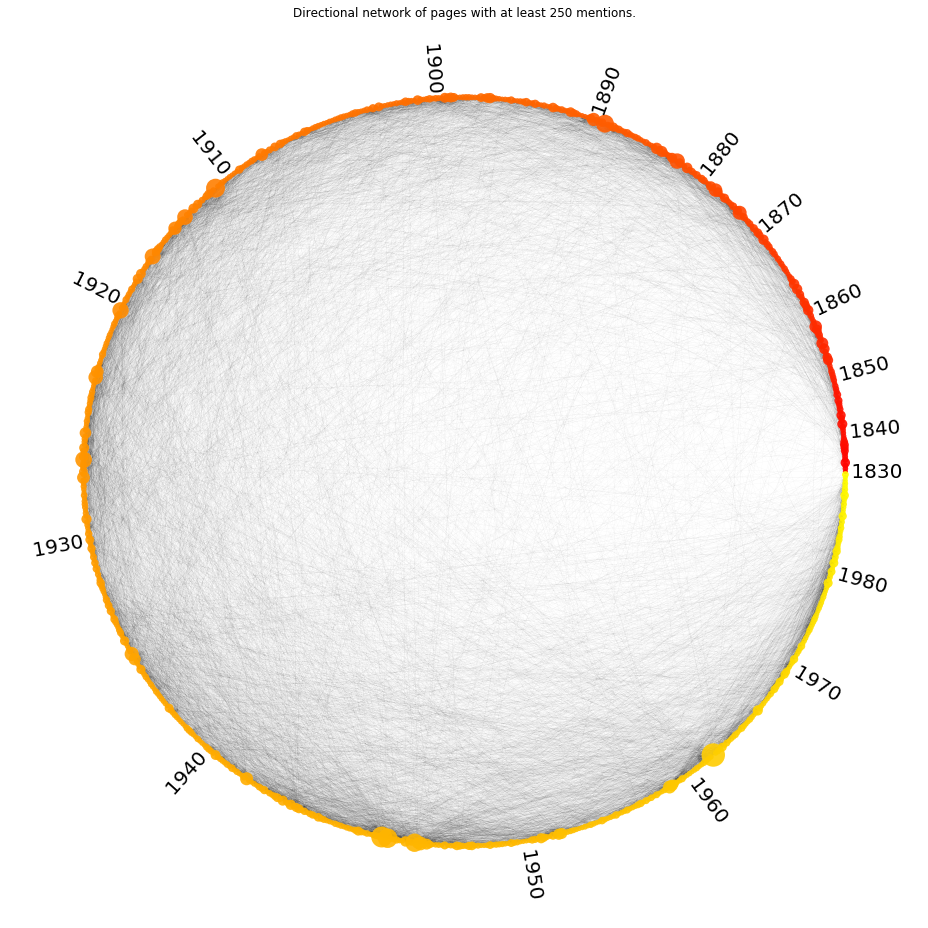

In [162]:
def return_year(key):
    return year_dict2[key]

#Creating a label dictionary containing the first person to be mentioned in a given decade
labels={}
start_year=1830
for lab in sorted(main_net2.nodes(),key=return_year):
    if year_dict2[lab]==start_year:
        labels[lab]=' {} '.format(year_dict2[lab])
        start_year+=10

# Node size and node color depending on the number of mentions and the birth year respectively
node_size = [0.1*nx.get_node_attributes(main_net2, 'number_mentions')[v] for v in main_net2]
node_color = [1*nx.get_node_attributes(main_net2, 'year')[v] for v in main_net2]

cmap = plt.cm.autumn
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

fig,ax=plt.subplots(figsize=(13,13))

#Network layout in a circular pattern
pos = nx.shell_layout(main_net2)

#Drawing nodes
nodes = nx.draw_networkx_nodes(main_net2, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                               norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9,
                              linewidths =0)
#Drawing edges
edges = nx.draw_networkx_edges(
    main_net2,
    pos,
    node_size=node_size,
    arrowstyle="->",
    arrowsize=10,
    width=0.05,
    alpha=0.2
)

#Drawing labels and changing the angle accordingly to the position in the network
labels=nx.draw_networkx_labels(main_net2,pos,labels,font_size=20,bold=True,font_color ='black')
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')
    
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Directional network of pages with at least {} mentions.'.format(minimum_mentions))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()

In [118]:
#Create list with shortest path from each pair of origin and destiny node
pathlengths=[]
for v in main_net2.nodes():
    spl = dict(nx.single_source_shortest_path_length(main_net2, v))
    for p in spl:
        if spl[p]==0:continue
        pathlengths.append(spl[p])
avg_shortest_path=sum(pathlengths) / len(pathlengths)
#for each node, find the shortest path. The diameter is the highest shortest path between two nodes in a network
diameter=(nx.diameter(main_net2))

#The nodes that have the highest shortest path equal to the diameter are in the periphery and are calculated below
periphery_nodes=nx.periphery(main_net2)

#for each node, find the shortest path. The radius is the minimum necessary distance for the central-most node to reach any other node
radius=nx.radius(main_net2)

#The nodes that have the highest shortest path equal to the radius are in the periphery and are shown below
central_nodes=nx.center(main_net2)

# Calculating the farthest node from a node in the periphery, as well as the shortest path between both
farthest_node=sorted(nx.shortest_path_length(main_net2,periphery_nodes[0]).items(),key=lambda item:item[1],reverse=True)[0][0]
shortest_path_two_nodes=nx.shortest_path(main_net2,periphery_nodes[0],farthest_node)

The network has a higher density of connections around the border region when compared to the center, which happens because the connections are likely to be between people born in a similar period.


In [119]:
md(('By calculating the shortest path between each pair of nodes and taking their average we find that it takes on average '
   '**{:.1f}** edges for each page to reach the other. \n From the histogram below, most nodes have a distance'
   ' of **3** edges between themselves.').format(avg_shortest_path))

NameError: name 'avg_shortest_path' is not defined

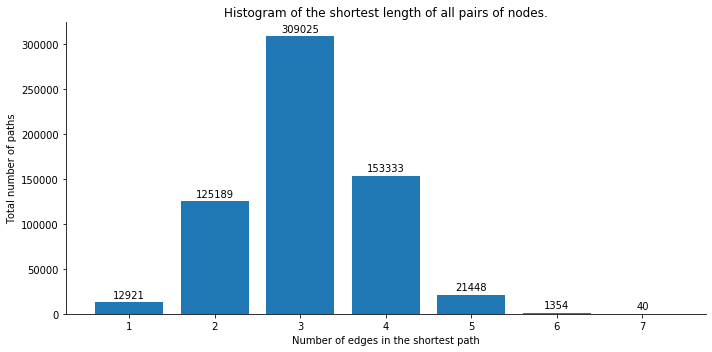

In [195]:
#Creating histogram by grouping node connections by their shortest path length
path_lengths_count=Counter(pathlengths)
fig,ax=plt.subplots(figsize=(10,5))
ax.bar(path_lengths_count.keys(),path_lengths_count.values())

for i, v in enumerate(path_lengths_count.keys()):
    ax.text(v, path_lengths_count[v]+5000, str(path_lengths_count[v]), color='black',ha='center')
plt.title('Histogram of the shortest length of all pairs of nodes.')
plt.xlabel('Number of edges in the shortest path')
plt.ylabel('Total number of paths')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
#plt.yscale('log')

In [178]:
farthest_node=sorted(nx.shortest_path_length(main_net2,periphery_nodes[0]).items(),key=lambda item:item[1],reverse=True)[0][0]
shortest_path_two_nodes=nx.shortest_path(main_net2,periphery_nodes[0],farthest_node)


In [194]:
md(('The largest distance between two nodes is equal to **{}**. As an example, to go from node "{}" to node "{}", '
    'the shortest path is: {}.')
    .format(diameter,periphery_nodes[0],farthest_node,' -> '.join(shortest_path_two_nodes)))

The largest distance between two nodes is equal to **7**. As an example, to go from node "Franz_Joseph_I_of_Austria" to node "Martina_Navratilova", the shortest path is: Franz_Joseph_I_of_Austria -> Pope_Pius_X -> Pope_Francis -> Ennio_Morricone -> David_Guetta -> Justin_Bieber -> Venus_Williams -> Martina_Navratilova.

In [193]:
md(('On the other hand, the most central nodes need to use only **{}** edges to reach all other nodes in the network.'
   'These nodes are: {}.').format(radius, ', '.join(central_nodes)))

On the other hand, the most central nodes need to use only **4** edges to reach all nodes in the network.These nodes are: Irving_Berlin, Harry_Belafonte, James_Brown, Warren_Beatty, Plácido_Domingo, Eric_Clapton, Rod_Stewart, Linda_Ronstadt, Sylvester_Stallone, Oliver_Stone, Elton_John, Phil_Collins, Elvis_Costello, Andrea_Bocelli, Celine_Dion, Shakira, Lady_Gaga

In [ ]:
#Getting centrality measurements
in_degree=nx.in_degree_centrality(main_net2).items()
out_degree=nx.out_degree_centrality(main_net2).items()
closeness_centr=nx.closeness_centrality(main_net2).items()
betweenness_centr=nx.betweenness_centrality(main_net2).items()
pagerank=nx.pagerank(main_net2,alpha=0.8).items()
hubs=nx.hits(main_net2)[0].items()
authorities=nx.hits(main_net2)[1].items()

#Obtaining top 10 values for each category
in_degree_10=sorted(in_degree,key=lambda x:x[1],reverse=True)[:10]
out_degree_10=sorted(out_degree,key=lambda x:x[1],reverse=True)[:10]
closeness_centr_10=sorted(closeness_centr,key=lambda x:x[1],reverse=True)[:10]
betweenness_centr_10=sorted(betweenness_centr,key=lambda x:x[1],reverse=True)[:10]
pagerank_10=sorted(pagerank,key=lambda x:x[1],reverse=True)[:10]
hubs_10=sorted(hubs,key=lambda x:x[1],reverse=True)[:10]
authorities_10=sorted(authorities,key=lambda x:x[1],reverse=True)[:10]


In [ ]:
df10=pd.DataFrame(map(list,zip(*[in_degree_10,out_degree_10,closeness_centr_10,betweenness_centr_10,pagerank_10,hubs_10,authorities_10])),
                 columns=['in_degree','out_degree','closeness_centrality','betweenness_centrality','pagerank','hubs','authorities'])
df10.index=[1,2,3,4,5,6,7,8,9,10]
df10.index.name='Rank'
df10

In [ ]:
#Function to plot network with focus on a specific person. Show both edges that come in and out of this node.
def plot_candidate(person,title):

    labels={lab:lab for lab in main_net2.nodes() if lab==person}
    colors=[]
    widths=[]
    for edge in main_net2.edges():
        if edge[0]==person:
            colors+=['blue']
            widths+=[3]

        elif edge[1]==person:
            colors+=['red']
            widths+=[3]
        else:
            colors+=['black']
            widths+=[0.05]

    node_size = [0.05*nx.get_node_attributes(main_net2, 'number_mentions')[v] for v in main_net2]
    node_color = [1*nx.get_node_attributes(main_net2, 'year')[v] for v in main_net2]

    cmap = plt.cm.autumn
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)))

    fig,ax=plt.subplots(figsize=(15,15))

    pos = nx.circular_layout(main_net2)
    
    theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items() }

    
    nodes = nx.draw_networkx_nodes(main_net2, pos, node_size=node_size, node_color=node_color,cmap=cmap,edgecolors='black',
                                   norm=plt.Normalize(vmin = min(node_color), vmax=max(node_color)),alpha=0.9,with_labels=False,
                                  linewidths =0)
    edges_draw = nx.draw_networkx_edges(
        main_net2,
        pos,
        node_size=node_size,
        arrowstyle="->",
        arrowsize=10,
        width=widths,
        alpha=0.2,
        edge_color=colors
    )
    labels=nx.draw_networkx_labels(main_net2,pos,labels,font_size=20,bold=True,font_color ='green')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.title(title)
    for key,t in labels.items():
        if 90 < theta[key] or theta[key] < -90 :
            angle = 180 + theta[key]
            t.set_ha('right')
        else:
            angle = theta[key]
            t.set_ha('left')
        t.set_va('center')
        t.set_rotation(angle)
        t.set_rotation_mode('anchor')
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.tight_layout()
    return 


In [ ]:
plot_candidate('Barack_Obama','Node with highest in_degree, closeness centrality, pagerank and authority')

In [ ]:
plot_candidate('Bob_Dylan','Node with highest out_degree')

In [ ]:
plot_candidate('George_W._Bush','Node with highest betweenness centrality')

In [ ]:
plot_candidate('Beyoncé','Node with highest hub metric')

In [ ]:
#Creating an unified dataset in order to select the top 10 nodes that best perform across the multiple rules.

df=pd.DataFrame(in_degree,columns=['name','in_degree'])
df=pd.merge(df,pd.DataFrame(out_degree,columns=['name','out_degree']),on='name')
df=pd.merge(df,pd.DataFrame(closeness_centr,columns=['name','closeness_centrality']),on='name')
df=pd.merge(df,pd.DataFrame(betweenness_centr,columns=['name','betweenness_centrality']),on='name')
df=pd.merge(df,pd.DataFrame(pagerank,columns=['name','pagerank']),on='name')
df=pd.merge(df,pd.DataFrame(hubs,columns=['name','hubs']),on='name')
df=pd.merge(df,pd.DataFrame(authorities,columns=['name','authorities']),on='name')

df.loc[:,'in_degree_rank']=df['in_degree'].rank(ascending=False)
df.loc[:,'out_degree_rank']=df['out_degree'].rank(ascending=False)
df.loc[:,'closeness_centr_rank']=df['closeness_centrality'].rank(ascending=False)
df.loc[:,'betweenness_centr_rank']=df['betweenness_centrality'].rank(ascending=False)
df.loc[:,'pagerank_rank']=df['pagerank'].rank(ascending=False)
df.loc[:,'hubs_rank']=df['hubs'].rank(ascending=False)
df.loc[:,'authorities_rank']=df['authorities'].rank(ascending=False)
df.loc[:,'rank_sum']=df['in_degree_rank']+df['out_degree_rank']+df['pagerank_rank']+df['hubs_rank']+df['closeness_centr_rank']+df['betweenness_centr_rank']+df['authorities_rank']

df.sort_values('rank_sum',ascending=True,inplace=True)
df.set_index('name',inplace=True)
df.head(10)